In [12]:
import multiprocessing as mp

import numpy as np
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

np.random.seed(0)
ox.__version__

'1.7.1'

In [2]:
place = "Paris, France"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

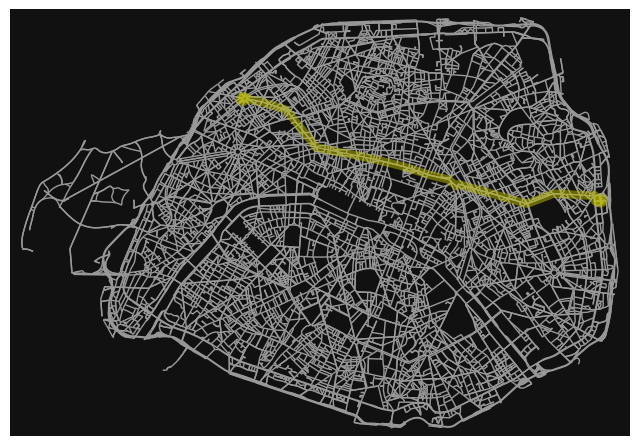

In [3]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

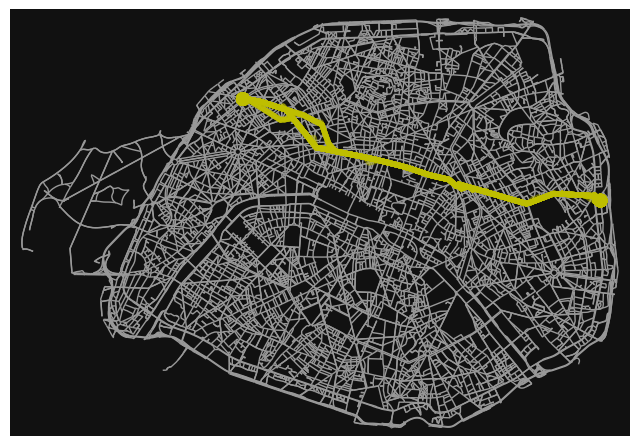

In [4]:
# k-shortest paths
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=4, node_size=0)

### Adding travel speeds and time to edges

In [5]:
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [8]:
# mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'tertiary']",115.1,25.0,16.5
"['primary', 'tertiary']",76.9,30.0,9.2
"['residential', 'living_street']",169.9,25.8,23.8
"['residential', 'tertiary']",152.1,30.0,18.2
"['secondary', 'secondary_link']",306.4,40.0,27.6
"['tertiary', 'primary']",76.9,30.0,9.2
"['tertiary', 'primary_link']",161.9,30.0,19.4
"['tertiary_link', 'trunk_link']",26.9,30.0,3.2
"['trunk', 'motorway']",570.6,60.0,34.2


In [9]:
# pass a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

# calculate routes with minimizing distance/travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

Route 1 is 9106 meters and takes 1038 seconds.
Route 2 is 14805 meters and takes 889 seconds.


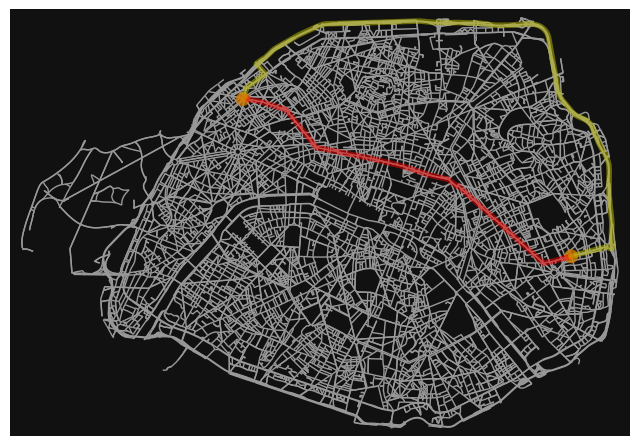

In [11]:
route1_length = int(sum(ox.utils_graph.route_to_gdf(G, route1, "length")["length"]))
route2_length = int(sum(ox.utils_graph.route_to_gdf(G, route2, "length")["length"]))
route1_time = int(sum(ox.utils_graph.route_to_gdf(G, route1, "travel_time")["travel_time"]))
route2_time = int(sum(ox.utils_graph.route_to_gdf(G, route2, "travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

### Isochrone map

In [13]:
network_type = "bike"
trip_times = [5, 10, 15, 20, 25]  # in minutes
# how far can you bike in 5 to 25 minutes from the source node?
travel_speed = 10  # biking speed in km/hour
place = "Paris, France"
G = ox.graph_from_place(place, network_type=network_type)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

c:\Users\Shaoxuan Zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Shaoxuan Zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Shaoxuan Zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [14]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

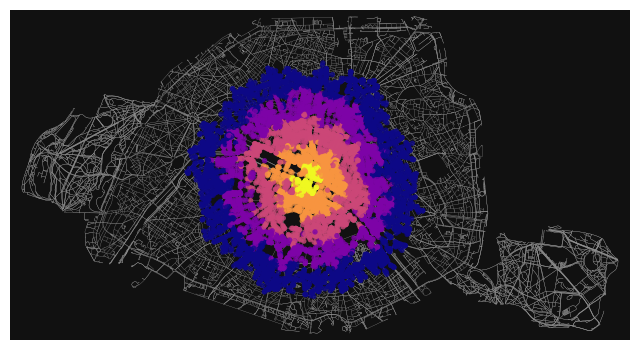

In [15]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [16]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

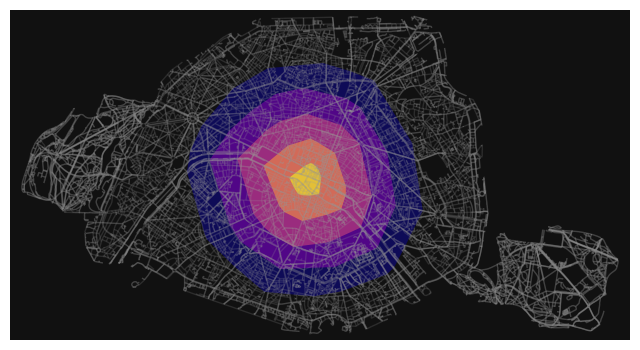

In [17]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

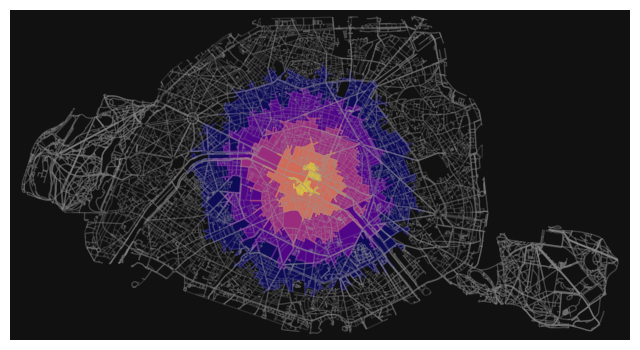

In [18]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()